# 라이브러리

In [1]:
import sys
sys.path.append("c:\\users\\samsung\\appdata\\local\\packages\\pythonsoftwarefoundation.python.3.8_qbz5n2kfra8p0\\localcache\\local-packages\\python38\\site-packages")

In [2]:
from kmodes.kprototypes import KPrototypes
import warnings
warnings.filterwarnings('ignore')

In [3]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime
import re

from tqdm import tqdm
import joblib
from sklearn.preprocessing import LabelEncoder
from kmodes.kprototypes import KPrototypes

from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:
    rc('font', family='AppleGothic')

# 데이터 불러오기

In [4]:
def call_df(table_name):
    with open('config.json', 'r') as f:
        config = json.load(f)
        
    conn = psycopg2.connect(user = config['USER'],
                              password = config['PASSWORD'],
                              host = config['HOST'],
                              port = config['PORT'],
                              database = config['DATABASE'])
    
    sql = f'SELECT * FROM {table_name}'
    df = pd.read_sql_query(sql, conn)
    conn.close()
    return df

In [5]:
district = call_df('crawling_db.district_table')
apartment = call_df('crawling_db.apartment_table').drop(columns='table_id')
school = call_df('crawling_db.school_table').drop(columns='table_id')
subway = call_df('crawling_db.subway_table').drop(columns='table_id')
price = call_df('crawling_db.price_table')

In [24]:
df = (apartment.
      merge(district, how='left', on='district_id').
      merge(school, how='left', on='apartment_id').
      merge(subway, how='left',on='apartment_id'))

In [25]:
df.head()

,district_id,apartment_id,apartment_addr_town,apartment_builder,apartment_build_year,apartment_build_month,apartment_floor_min,apartment_floor_max,apartment_parking,apartment_name,district_name,school_name,school_dist,school_addr_district,school_addr_town,school_students,st_name,st_dist,st_volume
0,13,9738,상수동,두산산업개발(주),2004,12,10,25,1.34,상수두산위브,마포구,서울서강초등학교,5,13,독막로,1012,상수역,0.001826,1
1,1,119219,개포동,삼성물산(주),2020,9,7,35,1.71,개포래미안포레스트,강남구,서울구룡초등학교,2,1,개포로,492,매봉역,0.009325,1
2,1,107513,개포동,상지건영(주),2003,3,10,10,2.27,개포상지리츠빌,강남구,서울개일초등학교,4,1,개포로,837,구룡역,0.002699,1
3,1,960,개포동,대한주택공사,1982,11,5,5,0.49,개포주공1단지,강남구,서울개원초등학교,1,1,선릉로,131,구룡역,0.007869,1
4,1,1289,개포동,대한주택공사,1982,11,5,5,0.40,개포주공4단지,강남구,서울양전초등학교,1,1,개포로,455,개포동역,0.004453,1


# 데이터 전처리

- 'apartment_build_month' 'school_name' 'school_addr_district' 'school_addr_town' 'apartment_floor_min', 'apartment_floor_max' 'apartment_parking' 'st_name' 'st_volume' >> 제거

In [26]:
df = df.drop(['apartment_build_month','school_name','school_addr_district','school_addr_town','apartment_floor_min','apartment_floor_max', 'apartment_parking','st_name','st_volume','school_dist'],axis=1)

## 숫자형 자료

In [27]:
df['school_students'] = pd.to_numeric(df['school_students'])

In [28]:
#준공연도 일의자리 수 제외하고 새롭게 설정
df['apartment_build_year'] = df['apartment_build_year'].apply(lambda x : x - x%10)

In [29]:
print(df.isna().sum())

district_id               0
apartment_id              0
apartment_addr_town       0
apartment_builder         0
apartment_build_year      0
apartment_name            0
district_name             0
school_students         840
st_dist                   0
dtype: int64


- 네이버에서 근처에 학교가 없을 경우, 학교가 없다고 인식하여 결측치가 발생합니다. 이를 0으로 대체하겠습니다.

In [30]:
df['school_students'] = df['school_students'].fillna(0)

### 정규화
- 표준정규분포 정규화

In [31]:
from sklearn.preprocessing import StandardScaler

def standard_scaler(data, variable):
    scaler = StandardScaler()
    scaler.fit(data[variable].values.reshape(-1,1))
    joblib.dump(scaler, f'./model/{variable}_scaler.pkl')

def scaling(data, variable):
    scaler = joblib.load(f'./model/{variable}_scaler.pkl')
    output = scaler.transform(data[variable].values.reshape(-1,1))
    return output

def inverse_scaling(data, variable):
    scaler = joblib.load(f'./model/{variable}_scaler.pkl')
    output = scaler.inverse_transform(data[variable].values.reshape(-1,1))
    return output 

In [32]:
numericals = [
    'school_students',
    'st_dist',
    ]

for variable in numericals:
    standard_scaler(df, variable)
    df[variable] = scaling(df, variable)

## 범주형 자료

In [39]:
labels = [
    'apartment_addr_town',
    'apartment_builder',
    ]

categoricals = [
    'district_id',
    'apartment_builder',
    'apartment_build_year',
    'apartment_addr_town'
    ]

In [34]:
def label_encoding(data, variable):
    encoder = joblib.load(f'./model/{variable}_encoder.pkl')
    output = encoder.transform(data[variable])
    return output

def label_decoding(data, variable):
    encoder = joblib.load(f'./model/{variable}_encoder.pkl')
    output = encoder.inverse_transform(data[variable])
    return output

In [36]:
for variable in labels:
    df[variable] = label_encoding(df, variable)

# Modeling 

## K-Prototypes Clustering

In [40]:
train = df[categoricals + numericals].copy()
print(len(categoricals))

4


In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8016 entries, 0 to 8015
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   district_id           8016 non-null   int64  
 1   apartment_builder     8016 non-null   int32  
 2   apartment_build_year  8016 non-null   int64  
 3   apartment_addr_town   8016 non-null   int32  
 4   school_students       8016 non-null   float64
 5   st_dist               8016 non-null   float64
dtypes: float64(2), int32(2), int64(2)
memory usage: 375.8 KB


In [43]:
n_pseudo = range(1,16)
cost = []
for i in tqdm(n_pseudo):
    kproto = KPrototypes(n_clusters=i, verbose=0, random_state=0, n_jobs=-1)
    kproto.fit_predict(train, categorical=list(range(len(categoricals))))
    cost.append(kproto.cost_)
cost_table = pd.DataFrame({'n':n_pseudo, 'cost':cost})

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [31:57<00:00, 127.83s/it]


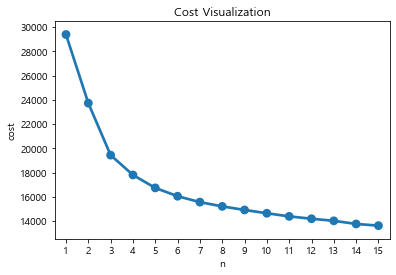

In [44]:
def cost_visualize(data, x, y):
    sns.pointplot(data=data, x=x, y=y)
    plt.title('Cost Visualization')
    plt.show()
cost_visualize(cost_table, 'n', 'cost')

- 적당한 k를 찾기 위해 Elbow Method를 사용합니다. Cost가 줄어드는 비율이 확연하게 줄어드는 지점이 유의미한 k라고 가정합니다. 위의 Cost 시각화 그래프에서 기울기의 절대값이 변동하는 비율이 0.1 이하로 떨어지며 클러스터 수가 작은 값을 적당한 k라고 정의하겠습니다.

In [45]:
cost_table['coef'] = abs(cost_table['cost'] - cost_table['cost'].shift(1))
cost_table['ratio'] =  abs((cost_table['coef'].shift(1) - cost_table['coef'])/cost_table['coef'])
optimal_k = cost_table.loc[cost_table['ratio'] <= 0.1]['n'].min()
print(f'가장 적당한 k는 {optimal_k}입니다.')

가장 적당한 k는 10입니다.


In [46]:
kproto = KPrototypes(n_clusters=optimal_k, verbose=0, random_state=0, n_jobs=-1)
train['cluster'] = kproto.fit_predict(train, categorical=list(range(len(categoricals))))
joblib.dump(kproto, './model/kprototype_model.pkl')

['./model/kprototype_model.pkl']

## Decoding Into Original

In [47]:
train['apartment_id'] = df['apartment_id']
train['apartment_name'] = df['apartment_name']
train['district_name'] = df['district_name']

for variable in numericals:
    train[variable] = inverse_scaling(train, variable)
for variable in labels:
    train[variable] = label_decoding(train, variable)  

In [48]:
train.to_pickle('./data/clustered_apartment.pkl')

In [49]:
clustered = pd.read_pickle('./data/clustered_apartment.pkl')